# Atividade computacional 3
### Módulo 03
#### IMPLEMENTAÇÃO DE UPSAMPLING E DOWNSAMPLING EM UM SINAL DE ÁUDIO
Autor: Ariel Lima Andrade<br>

#### Importando bibliotecas 

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft
import numpy as np
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

#### Minha caixa de ferramentas
Definição de funções genéricas.

In [9]:
def plotAudioSignalTime(data, title, xlabel, ylabel, figsize, duration):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    t = np.linspace(0., duration, data.shape[0])
    plt.plot(t, data[:])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

#### Reproduzindo o áudio - Freesound ([Trecho de sweep de frequência](https://freesound.org/people/kwahmah_02/sounds/262333/))
Áudio disponível no Freesound.

In [10]:
sound_file = './sweep_frequency.wav'
Audio(filename=sound_file, autoplay=False)

#### Carregando o áudio original em uma numpy array e convertendo de estéreo para mono

In [11]:
samplerate, source_audio = wavfile.read(sound_file)
print(f"Sample rate do áudio: {samplerate}Hz")
duration = source_audio.shape[0] / samplerate
print(f"Duração do áudio: {duration}s")

Sample rate do áudio: 44100Hz
Duração do áudio: 10.0s


#### Plotando o sinal no domínio do tempo

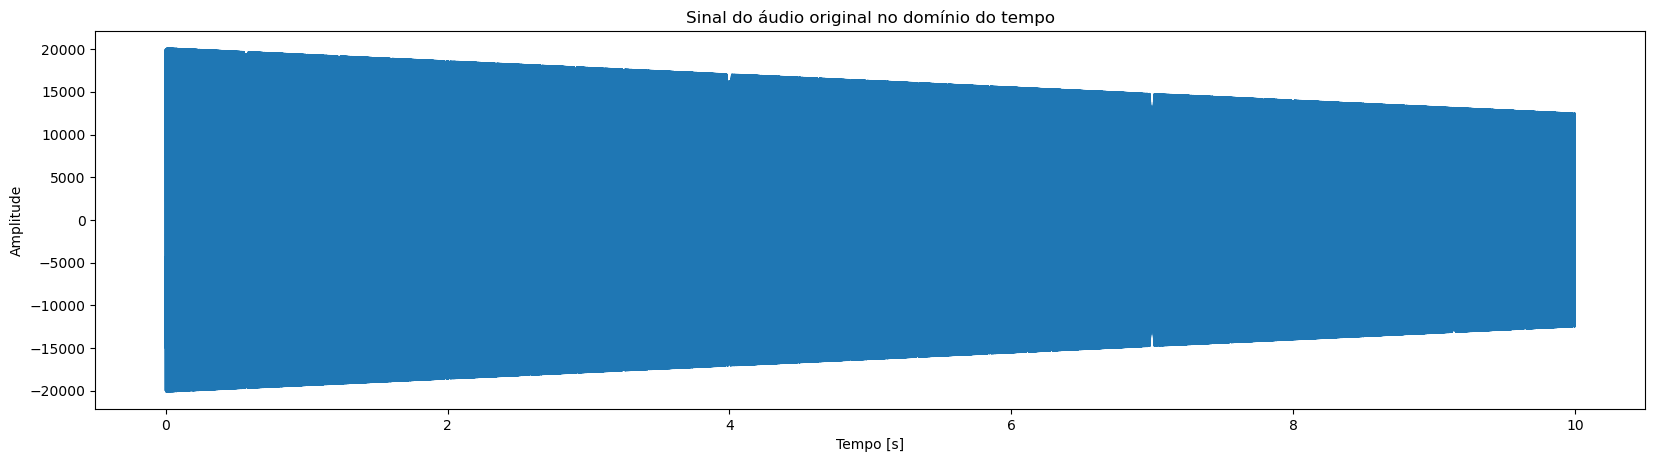

In [12]:
plotAudioSignalTime(source_audio, "Sinal do áudio original no domínio do tempo", "Tempo [s]", "Amplitude", (20, 5), duration)

#### Plotando o espectrograma

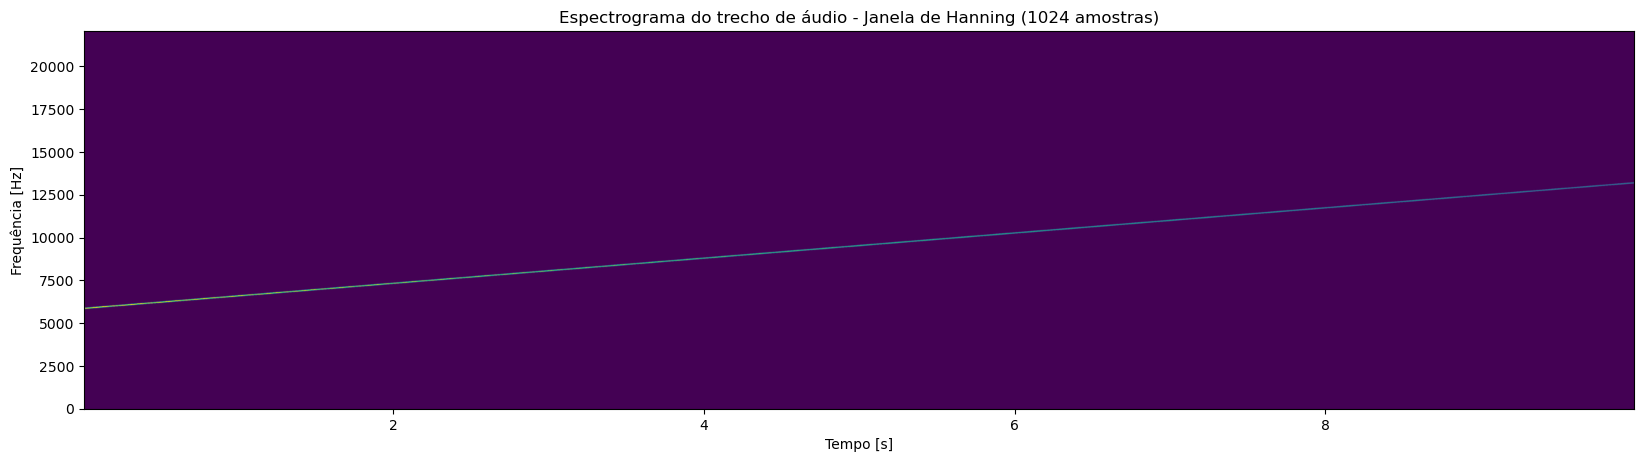

Reproduzir trecho de áudio:


In [13]:
fs = samplerate
window_size = 1024
window_type = 'hann'

f, t, Sxx = signal.spectrogram(source_audio, fs, nperseg=window_size, window=window_type)
figure(num=None, figsize=(20,5), dpi=100, facecolor='w', edgecolor='k')
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.title(f"Espectrograma do trecho de áudio - Janela de Hanning ({window_size} amostras)")
plt.show()

print("Reproduzir trecho de áudio:")
Audio(filename=sound_file, autoplay=False)

#### Calculando a FFT do sinal - Análise da frequência

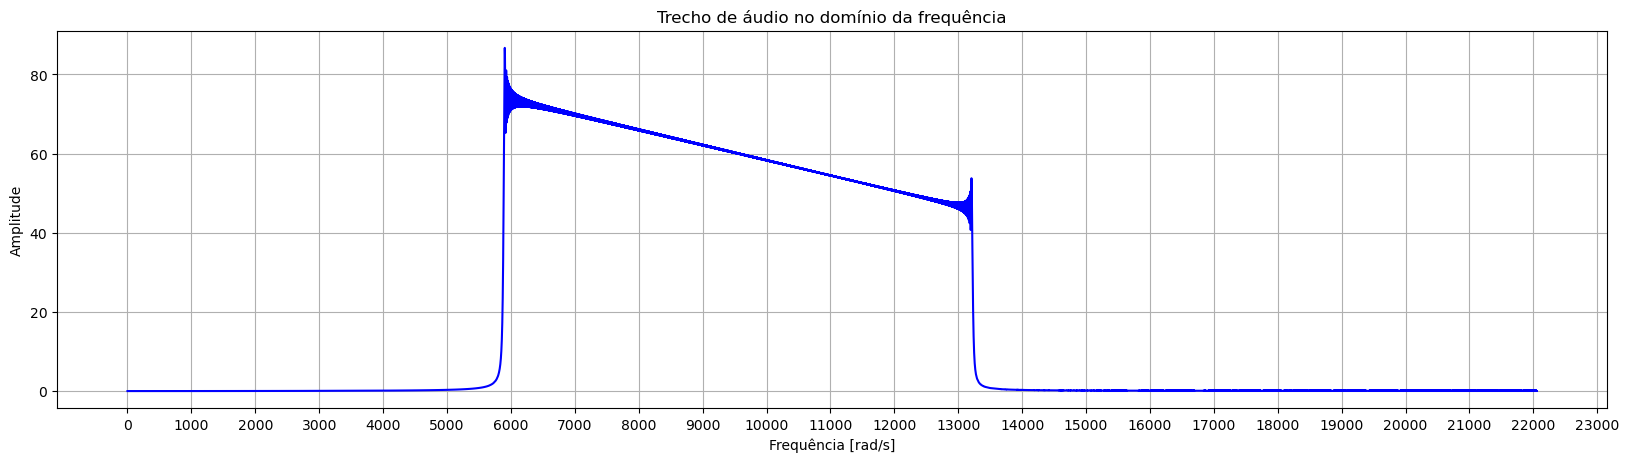

In [18]:
T = 1. / samplerate
N = source_audio.shape[0]
yf = fft(source_audio)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
figure(num=None, figsize=(20,5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), 'blue')
plt.xticks(np.arange(min(xf), max(xf) + 1000, 1000))
plt.grid()
plt.title("Trecho de áudio no domínio da frequência")
plt.ylabel('Amplitude')
plt.xlabel('Frequência [rad/s]')
plt.show()

#### Aplicando downsampling no sinal

Para realizar um downsampling no sinal utilizaremos o sistema abaixo: <br>
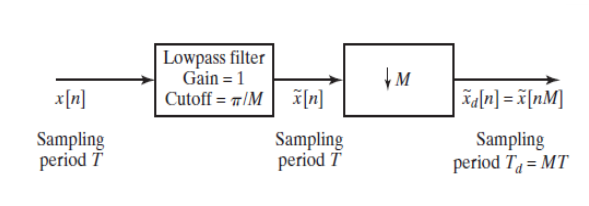<br>
Temos uma faixa de áudio gravada em uma taxa de amostragem de 44100Hz, ou seja, aproximadamente $T = 0.02267\ ms$.<br>
Queremos realizar downsampling por um fator de 2, para isso precisamos filtrar o sinal com um filtro passa-baixas com frequência de corte $\omega _c = \frac{\pi}{2}$ e com ganho 1. Evitando o aliasing ao utilizar o compressor com $M = 2$.<br>
O sinal de saída então possuirá uma taxa de amostragem de 22050Hz, ou seja, aproximadamente $T = 0.04535\ ms$.<br>

#### Aplicando o sistema utilizando a função decimate do SciPy - Signal

In [19]:
M = 2
downsampled_audio = signal.decimate(source_audio, M)

output_audio_downsampled = np.array(list(zip(downsampled_audio, downsampled_audio)), dtype=np.int16)

output_filename = "./downsampled_audio.wav"
wavfile.write(output_filename, samplerate // M, output_audio_downsampled) # Áudio salvo com frequência de amostragem dividida pelo fator de dizimação do sinal
Audio(filename=output_filename, autoplay=False)

#### Plotando o sinal subamostrado no domínio do tempo

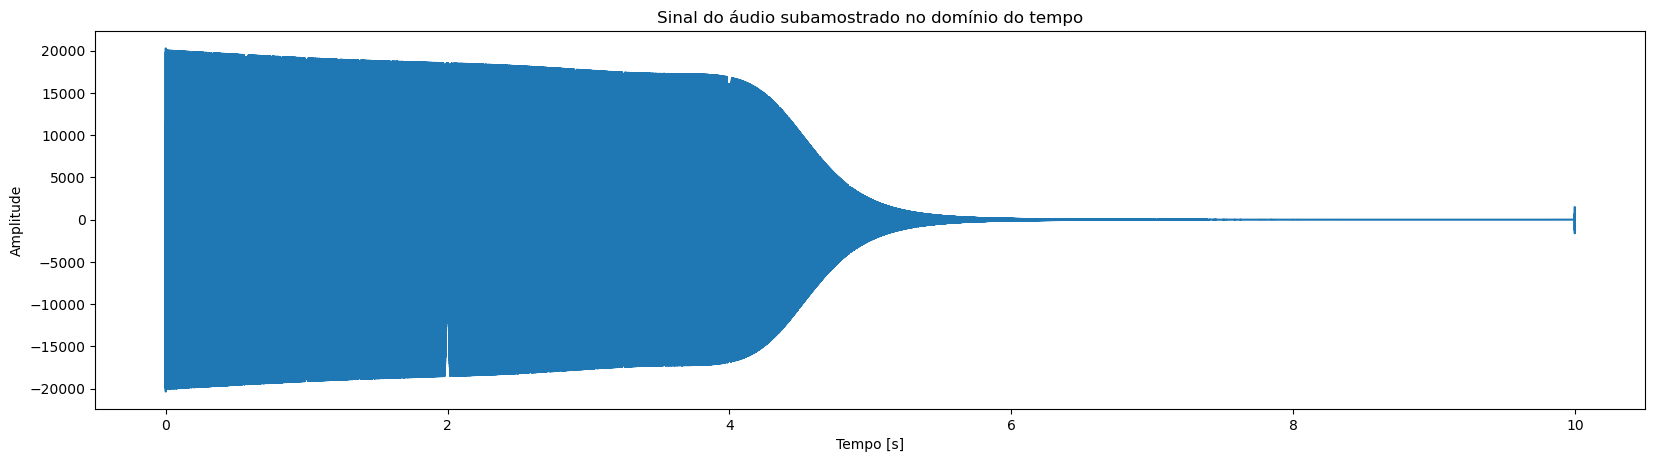

In [20]:
plotAudioSignalTime(downsampled_audio, "Sinal do áudio subamostrado no domínio do tempo", "Tempo [s]", "Amplitude", (20, 5), duration)

#### Plotando o espectrograma do sinal subamostrado

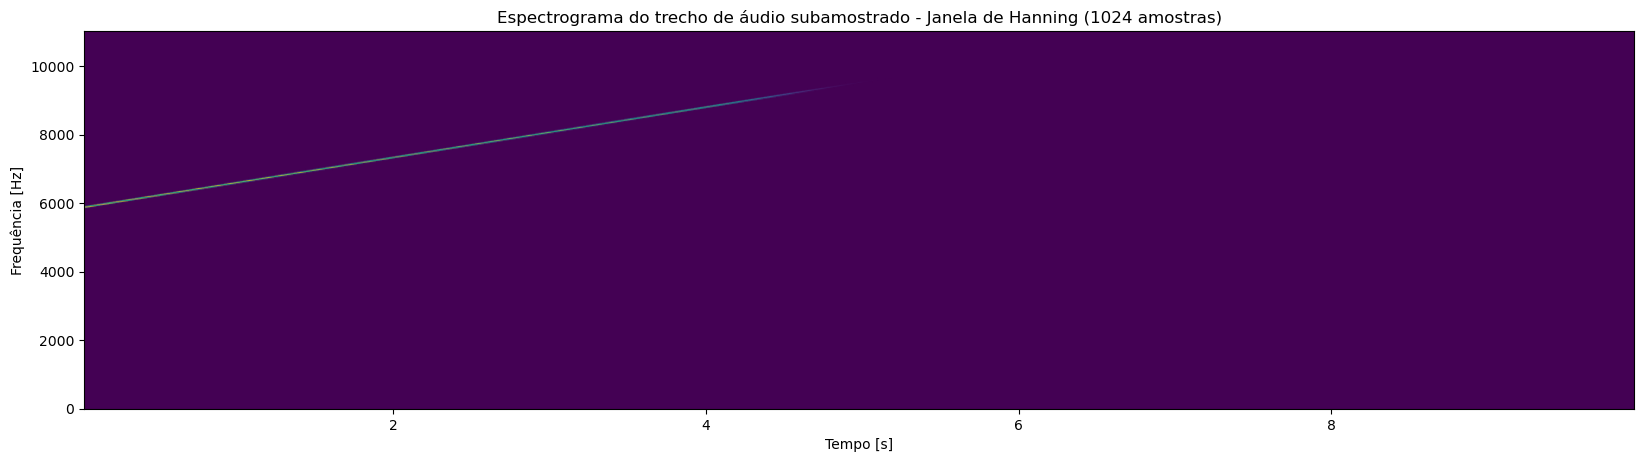

In [22]:
fs = samplerate / M # Note que a frequência de amostragem agora é dividida pelo fator M da dizimação.
window_size = 1024
window_type = 'hann'

f, t, Sxx = signal.spectrogram(downsampled_audio, fs, nperseg=window_size, window=window_type)
figure(num=None, figsize=(20,5), dpi=100, facecolor='w', edgecolor='k')
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.title(f"Espectrograma do trecho de áudio subamostrado - Janela de Hanning ({window_size} amostras)")
plt.show()

#### Calculando a FFT do sinal subamostrado - Análise da frequência comparada ao sinal de áudio original

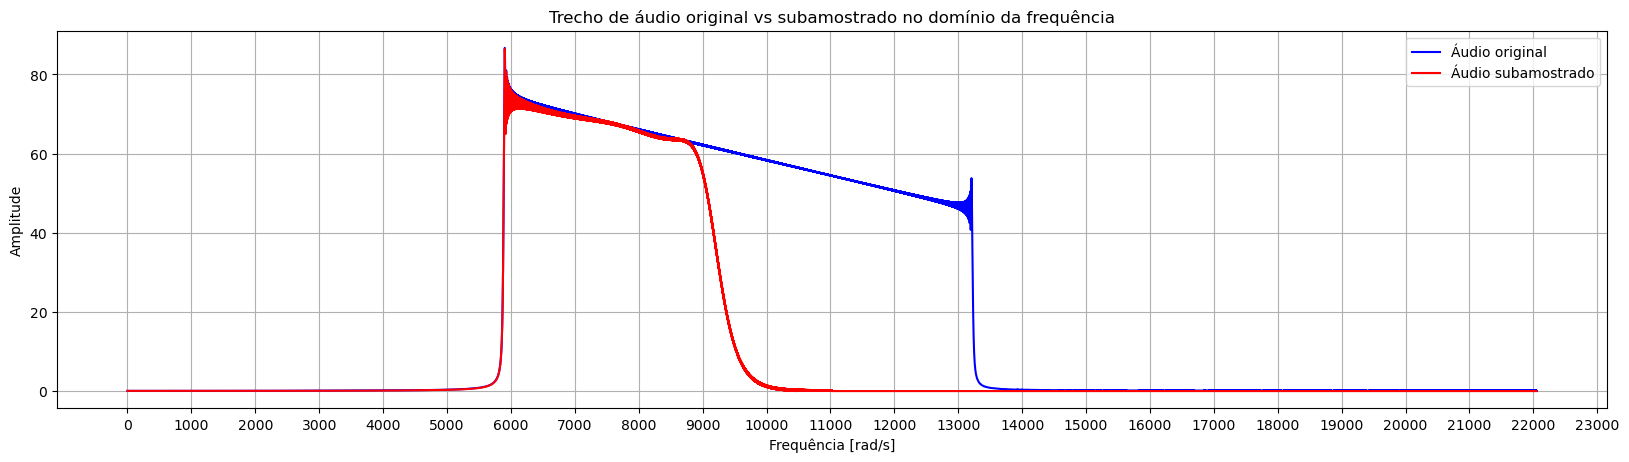

(220500,)

In [67]:
T1 = 1. / (samplerate / M) 
N1 = downsampled_audio.shape[0]

T2 = 1. / samplerate
N2 = source_audio.shape[0]

yf1 = fft(downsampled_audio)
yf1 = np.append(yf1[0:N1//2], np.zeros(N1//2)) # Zerando as frequências maiores que a escala do gráfico
xf1 = np.linspace(0.0, 2.0/(2.0*T1), N1) # Ajustando escalas de frequência do gráfico


yf2 = fft(source_audio)
xf2 = np.linspace(0.0, 1.0/(2.0*T2), N2//2)


figure(num=None, figsize=(20,5), dpi=100, facecolor='w', edgecolor='k')
plt.plot(xf2, 2.0/N2 * np.abs(yf2[0:N2//2]), 'blue',  label='Áudio original')
plt.plot(xf1, 2.0/N1 * np.abs(yf1), 'red', label='Áudio subamostrado')
plt.xticks(np.arange(min(xf1), max(xf2) + 1000, 1000))
plt.grid()
plt.title("Trecho de áudio original vs subamostrado no domínio da frequência")
plt.ylabel('Amplitude')
plt.xlabel('Frequência [rad/s]')
plt.legend()
plt.show()
yf1.shape

